In [35]:
# external imports
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

# internal imports
import sys
sys.path.insert(0,'../')
from data_utils import add_deltas_and_time, scale_data, add_extreme, add_lifetime, column_combinations

In [28]:
data_850 = pd.read_csv('../NA850data_2000-2014.csv')
data_w_extreme = add_extreme(data_850)
data_w_time_deltas = add_deltas_and_time(data_w_extreme)
data_w_lifetime = add_lifetime(data_w_time_deltas)

In [29]:
# get scaled provided data with deltas and time added
X = data_w_lifetime.drop(columns=['LH', 'dLH', "Extreme", "dExtreme"])
X = scale_data(X)

y = data_w_lifetime['LH']
y_extreme = data_w_lifetime['Extreme']

X.head()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,Lat,Lon,PtIndex,WaveTrajectory,dAirTemp,dQV,dOmega,dSeaLevPress,dUWinds,dVWinds,dLat,dLon,LifeTime
Time,,,,,,,,,,,,,,,,,,,
2000-01-01 03:00:00,-6.088163,-0.910811,0.080339,2.180997,-0.718670,-1.008888,1.243533,0.004734,-0.954545,-1.168067,0.091148,0.195511,-0.799627,-0.251402,0.394266,1.285404,-1.218041,-1.279085,-1.50
2000-01-01 06:00:00,-6.107434,-0.943091,0.476626,1.966440,-0.527986,-0.698457,1.264110,-0.049866,-0.909091,-1.168067,-0.035440,-0.160021,0.530617,-0.388836,0.580967,0.711946,0.271371,-0.790392,-1.50
2000-01-01 09:00:00,-5.950378,-1.005994,0.800095,2.043946,-0.458774,-0.685136,1.199761,-0.092620,-0.863636,-1.168067,0.483702,-0.295208,0.433411,0.098812,0.214843,0.011722,-1.105129,-0.386217,-1.50
2000-01-01 12:00:00,-5.787819,-0.943555,0.508682,2.555672,-0.569586,-0.490811,1.229895,-0.155015,-0.818182,-1.168067,0.499905,0.258125,-0.387412,0.823818,-0.327761,0.438309,0.426290,-1.056380,-1.25
2000-01-01 15:00:00,-5.531023,-0.874945,0.388518,2.123726,-0.611146,-0.452270,1.246959,-0.213574,-0.772727,-1.168067,0.777359,0.285370,-0.158807,-0.751805,-0.119031,0.071160,0.214437,-0.925509,-1.25


In [30]:
undersampler = RandomUnderSampler(sampling_strategy=1, random_state=5)
X_under, y_extreme_under = undersampler.fit_resample(X, y_extreme)
y_under = y[undersampler.sample_indices_]

In [31]:
LQ = data_850.LH.quantile(0.25)
UQ = data_850.LH.quantile(0.75)
bound = 1.5 * (UQ - LQ)  # Whisker length * IQR
lower_bound = LQ - bound
upper_bound = UQ + bound

def classify_extremes(y_pred):
    return np.where((y_pred > upper_bound) | (y_pred < lower_bound), 1, 0)

In [32]:
X_train, X_test, y_train, y_test, y_ex_train, y_ex_test = \
    train_test_split(X_under, y_under, y_extreme_under, test_size=0.2, random_state=2)
# Allow a decision tree to grow to its full depth


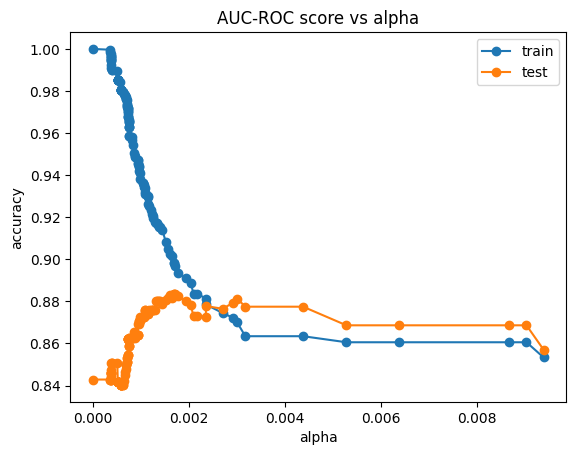

In [33]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_ex_train)

# compute ccp_alpha values
path = clf.cost_complexity_pruning_path(X_train, y_ex_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# train DT classifier for each ccp_alpha value
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_ex_train)
    clfs.append(clf)

# Plot train and test score for each of the above trained model    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [roc_auc_score(y_ex_train, clf.predict(X_train)) for clf in clfs]
test_scores = [roc_auc_score(y_ex_test, clf.predict(X_test)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

In [34]:
train_scores

[1.0,
 0.9996138996138997,
 0.9984186804903937,
 0.9976464797181929,
 0.9968496669691889,
 0.9964635665830885,
 0.9960651602085866,
 0.9956790598224862,
 0.9952806534479841,
 0.9948945530618838,
 0.9945084526757835,
 0.9941100463012815,
 0.9921795443707795,
 0.9909843252472734,
 0.9901875124982694,
 0.9901875124982694,
 0.9893906997492654,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9854312479810486,
 0.9842360288575428,
 0.980674983463828,
 0.980674983463828,
 0.980674983463828,
 0.980674983463828,
 0.980674983463828,
 0.980674983463828,
 0.980674983463828,
 0.9803011890661293,
 0.9795166823055269,
 0.9795166823055269,
 0.978719869556523,
 0.9779599747727237,
 0.9775615683982217,
 0.9771754680121214,
 0.9763786552631174,
 0.9760048608654187,
 0.9756064544909167,
 0.9736759525604147,
 0.9732898521743143,
 0.9728914457998122,
 0.972505345413

In [37]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

clf = DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_train, y_ex_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_ex_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_ex_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
CV score for GS 0.8977839623349843
Train AUC ROC Score for GS:  0.8778230706517559
Test AUC ROC Score for GS:  0.8669458667534851


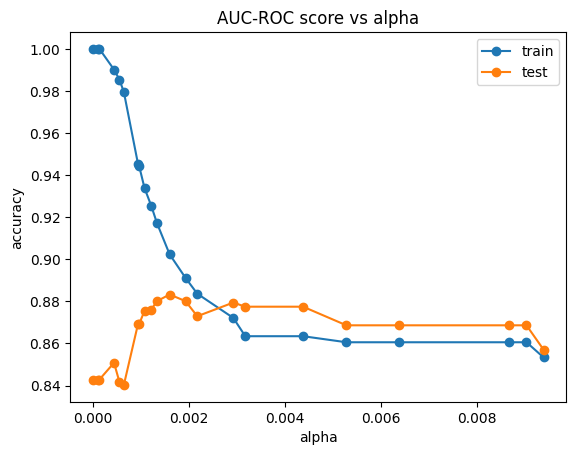

In [38]:
clf = DecisionTreeClassifier(random_state=42, max_depth= 5, min_samples_leaf= 5, min_samples_split=2)
clf.fit(X_train, y_ex_train)

# compute ccp_alpha values
path = clf.cost_complexity_pruning_path(X_train, y_ex_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# train DT classifier for each ccp_alpha value
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_ex_train)
    clfs.append(clf)

# Plot train and test score for each of the above trained model    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [roc_auc_score(y_ex_train, clf.predict(X_train)) for clf in clfs]
test_scores = [roc_auc_score(y_ex_test, clf.predict(X_test)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("ROC AUC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

In [64]:
clf = DecisionTreeClassifier(random_state=42, max_depth= 5, min_samples_leaf= 5, min_samples_split=2, ccp_alpha=0.003)
clf.fit(X_train, y_ex_train)
log_csv = []

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

log_csv.append(
        [
        mean_squared_error(y_train, y_pred_train),  # train MSE
        mean_squared_error(y_test, y_pred_test),  # test MSE
        r2_score(y_train, y_pred_train),  # train r^2
        r2_score(y_test, y_pred_test),  # test r^2
        accuracy_score(y_ex_train, y_pred_train),  # train accuracy
        accuracy_score(y_ex_test, y_pred_test),  # test accuracy
        f1_score(y_ex_train, y_pred_train),  # train f1
        f1_score(y_ex_test, y_pred_test)]  # test f1
    )

In [65]:
log_csv

[[1095.9785060247696,
  1246.7244143496216,
  -0.46805977800015475,
  -0.47233342444914017,
  0.8701960784313726,
  0.8793103448275862,
  0.8665860540104796,
  0.88208269525268]]

In [70]:
preselected_features = ["AirTemp", "QV", "Omega", "VWinds"]
features_to_select = [feature for feature in X.columns if feature not in preselected_features]

In [75]:
X_train, X_test, y_train, y_test, y_ex_train, y_ex_test = \
    train_test_split(X_under, y_under, y_extreme_under, test_size=0.2, random_state=2)

# initialize metric list
log_csv = []
for comb in column_combinations(features_to_select, max_len=5):
    # train and test inputs
    features_selected = preselected_features + comb
    X_train_feat = X_train[features_selected]
    X_test_feat = X_test[features_selected]
    dt = DecisionTreeClassifier(random_state=42, max_depth= 5, min_samples_leaf= 5, min_samples_split=2, ccp_alpha=0.003)
    
    # fit and predict train and test
    dt.fit(X_train_feat, y_ex_train)
    y_pred_train = dt.predict(X_train_feat)
    y_pred_test = dt.predict(X_test_feat)

    # log training and testing metrics to list
    log_csv.append(
        [features_selected,
        mean_squared_error(y_train, y_pred_train),  # train MSE
        mean_squared_error(y_test, y_pred_test),  # test MSE
        r2_score(y_train, y_pred_train),  # train r^2
        r2_score(y_test, y_pred_test),  # test r^2
        accuracy_score(y_ex_train, y_pred_train),  # train accuracy
        accuracy_score(y_ex_test, y_pred_test),  # test accuracy
        f1_score(y_ex_train, y_pred_train),  # train f1
        f1_score(y_ex_test, y_pred_test)]  # test f1
    )

[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.8623529411764705, 0.8636363636363636, 0.8601036269430052, 0.8687782805429864]]
[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.8623529411764705, 0.8636363636363636, 0.8601036269430052, 0.8687782805429864], [['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds'], 1095.9096300488056, 1246.7548386380868, -0.46796751884595866, -0.472369354359798, 0.8717647058823529, 0.877742946708464, 0.8685162846803378, 0.8810975609756098]]
[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.8623529411764705, 0.8636363636363636, 0.8601036269430052, 0.8687782805429864], [['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds'], 1095.9096300488056, 1246.7548386380868, -0.46796751884595866, -0.472369354359798, 0.87176

[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.8623529411764705, 0.8636363636363636, 0.8601036269430052, 0.8687782805429864], [['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds'], 1095.9096300488056, 1246.7548386380868, -0.46796751884595866, -0.472369354359798, 0.8717647058823529, 0.877742946708464, 0.8685162846803378, 0.8810975609756098]]
[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.8623529411764705, 0.8636363636363636, 0.8601036269430052, 0.8687782805429864], [['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds'], 1095.9096300488056, 1246.7548386380868, -0.46796751884595866, -0.472369354359798, 0.8717647058823529, 0.877742946708464, 0.8685162846803378, 0.8810975609756098]]
[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.862352

[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.8623529411764705, 0.8636363636363636, 0.8601036269430052, 0.8687782805429864], [['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds'], 1095.9096300488056, 1246.7548386380868, -0.46796751884595866, -0.472369354359798, 0.8717647058823529, 0.877742946708464, 0.8685162846803378, 0.8810975609756098]]
[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.8623529411764705, 0.8636363636363636, 0.8601036269430052, 0.8687782805429864], [['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds'], 1095.9096300488056, 1246.7548386380868, -0.46796751884595866, -0.472369354359798, 0.8717647058823529, 0.877742946708464, 0.8685162846803378, 0.8810975609756098]]
[[['AirTemp', 'QV', 'Omega', 'VWinds', 'SeaLevPress'], 1095.6338557286667, 1246.643200599589, -0.46759812000740864, -0.472237514144247, 0.862352

KeyboardInterrupt: 

In [76]:
log_csv_sorted = sorted(log_csv, key=lambda l: l[-1], reverse=True)  # sort by max testing f1
# convert to dataframe and write to file
log_df = pd.DataFrame(log_csv_sorted, columns=["feature_combination", "train_MSE",
                                               "test_MSE", "train_r^2", "test_r^2", "train_acc",
                                               "test_acc", "train_F1", "test_F1"])
log_df.to_csv("tree_results_optimized.csv", sep="|", index=False)
log_df[:10]

,feature_combination,train_MSE,test_MSE,train_r^2,test_r^2,train_acc,test_acc,train_F1,test_F1
0,"[AirTemp, QV, Omega, VWinds, UWinds, Lon]",1095.978506,1246.724414,-0.468060,-0.472333,0.870196,0.879310,0.866586,0.882083
1,"[AirTemp, QV, Omega, VWinds, dOmega]",1094.931292,1246.071000,-0.466657,-0.471562,0.865882,0.874608,0.867133,0.881306
2,"[AirTemp, QV, Omega, VWinds, SeaLevPress, dOmega]",1094.931292,1246.071000,-0.466657,-0.471562,0.865882,0.874608,0.867133,0.881306
3,"[AirTemp, QV, Omega, VWinds, Lat, dOmega]",1094.931292,1246.071000,-0.466657,-0.471562,0.865882,0.874608,0.867133,0.881306
4,"[AirTemp, QV, Omega, VWinds, UWinds]",1095.909630,1246.754839,-0.467968,-0.472369,0.871765,0.877743,0.868516,0.881098
5,"[AirTemp, QV, Omega, VWinds, SeaLevPress, UWinds]",1095.909630,1246.754839,-0.467968,-0.472369,0.871765,0.877743,0.868516,0.881098
6,"[AirTemp, QV, Omega, VWinds, UWinds, Lat]",1095.909630,1246.754839,-0.467968,-0.472369,0.871765,0.877743,0.868516,0.881098
7,"[AirTemp, QV, Omega, VWinds, UWinds, PtIndex]",1095.909630,1246.754839,-0.467968,-0.472369,0.871765,0.877743,0.868516,0.881098
8,"[AirTemp, QV, Omega, VWinds, UWinds, WaveTraje...",1095.909630,1246.754839,-0.467968,-0.472369,0.871765,0.877743,0.868516,0.881098
9,"[AirTemp, QV, Omega, VWinds, UWinds, dAirTemp]",1095.909630,1246.754839,-0.467968,-0.472369,0.871765,0.877743,0.868516,0.881098


[[['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds', 'Lon', 'Lat'], 1095.9785060247696, 1246.7244143496216, -0.46805977800015475, -0.47233342444914017, 0.8701960784313726, 0.8793103448275862, 0.8665860540104796, 0.88208269525268]]


[Text(0.4, 0.9166666666666666, 'Omega <= -0.93\ngini = 0.5\nsamples = 2550\nvalue = [1295, 1255]'),
 Text(0.2, 0.75, 'Omega <= -2.499\ngini = 0.197\nsamples = 1135\nvalue = [126, 1009]'),
 Text(0.1, 0.5833333333333334, 'gini = 0.07\nsamples = 720\nvalue = [26, 694]'),
 Text(0.3, 0.5833333333333334, 'gini = 0.366\nsamples = 415\nvalue = [100, 315]'),
 Text(0.6, 0.75, 'Omega <= 2.044\ngini = 0.287\nsamples = 1415\nvalue = [1169, 246]'),
 Text(0.5, 0.5833333333333334, 'UWinds <= -0.503\ngini = 0.271\nsamples = 1389\nvalue = [1165, 224]'),
 Text(0.3, 0.4166666666666667, 'Lon <= 0.163\ngini = 0.429\nsamples = 372\nvalue = [256, 116]'),
 Text(0.2, 0.25, 'VWinds <= -0.805\ngini = 0.482\nsamples = 267\nvalue = [159, 108]'),
 Text(0.1, 0.08333333333333333, 'gini = 0.434\nsamples = 44\nvalue = [14, 30]'),
 Text(0.3, 0.08333333333333333, 'gini = 0.455\nsamples = 223\nvalue = [145, 78]'),
 Text(0.4, 0.25, 'gini = 0.141\nsamples = 105\nvalue = [97, 8]'),
 Text(0.7, 0.4166666666666667, 'AirTemp <= -

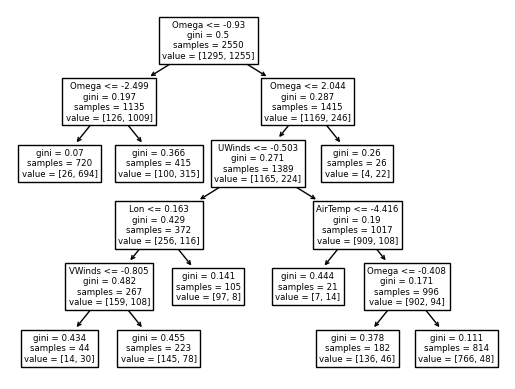

In [96]:
from sklearn import tree

X_train, X_test, y_train, y_test, y_ex_train, y_ex_test = \
    train_test_split(X_under, y_under, y_extreme_under, test_size=0.2, random_state=2)
preselected_features = ["AirTemp", "QV", "Omega", "VWinds",'UWinds', 'Lon']

# initialize metric list
log_csv = []
# train and test inputs
features_selected = preselected_features
X_train_feat = X_train[features_selected]
X_test_feat = X_test[features_selected]
dt = DecisionTreeClassifier(random_state=42, max_depth= 5, min_samples_leaf= 5, min_samples_split=2, ccp_alpha=0.003)

# fit and predict train and test
dt.fit(X_train_feat, y_ex_train)
y_pred_train = dt.predict(X_train_feat)
y_pred_test = dt.predict(X_test_feat)

# log training and testing metrics to list
log_csv.append([
    features_selected,
    mean_squared_error(y_train, y_pred_train),  # train MSE
    mean_squared_error(y_test, y_pred_test),  # test MSE
    r2_score(y_train, y_pred_train),  # train r^2
    r2_score(y_test, y_pred_test),  # test r^2
    accuracy_score(y_ex_train, y_pred_train),  # train accuracy
    accuracy_score(y_ex_test, y_pred_test),  # test accuracy
    f1_score(y_ex_train, y_pred_train),  # train f1
    f1_score(y_ex_test, y_pred_test)]  # test f1
)
print(log_csv)
tree.plot_tree(dt, feature_names=preselected_features)